<a href="https://colab.research.google.com/github/poojamahajan0712/medium_blog/blob/master/regularisation/MNIST_with_DropOut.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [ ]:
#1. Import libraries 
#!pip install torchsummary

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
from torchvision import datasets, transforms
from torchsummary import summary
import matplotlib.pyplot as plt

In [ ]:
# 2. Loading and transforming dataset 
#Transformations
#Transforms are common image transformations. They can be chained together using Compose
transforms = transforms.Compose([
                                 transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))  
                                      
                                       ])

train = datasets.MNIST('./data', train=True, download=True, transform=transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=transforms)

SEED = 1
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)
# For reproducibility
torch.manual_seed(SEED)
if cuda:
    torch.cuda.manual_seed(SEED)

dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

#you have to use data loader in PyTorch that will actually read the data within batch size and put into memory
# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)
# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


CUDA Available? True


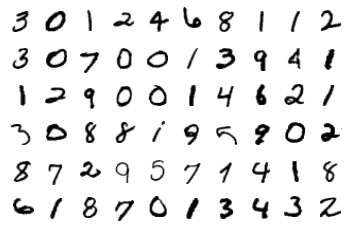

In [ ]:
#3 View few images from train data 
# loading one set of train data batch 

dataiter = iter(train_loader)
images, labels = dataiter.next()

figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [ ]:
#4 Building network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 26  RF 3 Jout - 1

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 24 RF 5 Jout -1

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 22 RF 7 Jout - 1

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11  RF 8 Jout - 2

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 11  RF 8 Jout- 2

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 9  RF - 12 ,Jout - 2
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 7 RF - 16  Jout - 2

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 7  RF - 16  Jout - 2 
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(7, 7), padding=0, bias=False),
            # nn.ReLU() NEVER!
        ) # output_size = 1  RF -28  Jout - 2 
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.dropout(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.dropout(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [ ]:
#5 Model Summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
print("Model Summary")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
Model Summary
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
            Conv2d-3           [-1, 10, 24, 24]             900
              ReLU-4           [-1, 10, 24, 24]               0
            Conv2d-5           [-1, 20, 22, 22]           1,800
              ReLU-6           [-1, 20, 22, 22]               0
           Dropout-7           [-1, 20, 22, 22]               0
         MaxPool2d-8           [-1, 20, 11, 11]               0
            Conv2d-9           [-1, 10, 11, 11]             200
             ReLU-10           [-1, 10, 11, 11]               0
           Conv2d-11             [-1, 10, 9, 9]             900
             ReLU-12             [-1, 10, 9, 9]               0
           Conv2d-13             [-1, 20, 7, 7]           1,800
             ReLU-14

In [ ]:
#6 training the network 
train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [ ]:

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)



  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 1


Loss=0.21388721466064453 Batch_id=468 Accuracy=41.68: 100%|██████████| 469/469 [00:20<00:00, 22.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2607, Accuracy: 9240/10000 (92.40%)

EPOCH: 2


Loss=0.0833626314997673 Batch_id=468 Accuracy=94.34: 100%|██████████| 469/469 [00:20<00:00, 22.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1035, Accuracy: 9701/10000 (97.01%)

EPOCH: 3


Loss=0.14022162556648254 Batch_id=468 Accuracy=96.58: 100%|██████████| 469/469 [00:20<00:00, 22.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0737, Accuracy: 9796/10000 (97.96%)

EPOCH: 4


Loss=0.05696272477507591 Batch_id=468 Accuracy=97.25: 100%|██████████| 469/469 [00:20<00:00, 22.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0683, Accuracy: 9781/10000 (97.81%)

EPOCH: 5


Loss=0.11344993114471436 Batch_id=468 Accuracy=97.62: 100%|██████████| 469/469 [00:20<00:00, 22.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0571, Accuracy: 9842/10000 (98.42%)

EPOCH: 6


Loss=0.08827650547027588 Batch_id=468 Accuracy=97.88: 100%|██████████| 469/469 [00:20<00:00, 22.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0556, Accuracy: 9842/10000 (98.42%)

EPOCH: 7


Loss=0.11176393181085587 Batch_id=468 Accuracy=98.08: 100%|██████████| 469/469 [00:20<00:00, 22.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0535, Accuracy: 9845/10000 (98.45%)

EPOCH: 8


Loss=0.03858974948525429 Batch_id=468 Accuracy=98.19: 100%|██████████| 469/469 [00:20<00:00, 22.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0560, Accuracy: 9858/10000 (98.58%)

EPOCH: 9


Loss=0.04853992164134979 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:20<00:00, 22.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0420, Accuracy: 9866/10000 (98.66%)

EPOCH: 10


Loss=0.00739171402528882 Batch_id=468 Accuracy=98.35: 100%|██████████| 469/469 [00:20<00:00, 23.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0477, Accuracy: 9851/10000 (98.51%)

EPOCH: 11


Loss=0.03369234874844551 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:20<00:00, 22.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0402, Accuracy: 9878/10000 (98.78%)

EPOCH: 12


Loss=0.02712228149175644 Batch_id=468 Accuracy=98.51: 100%|██████████| 469/469 [00:20<00:00, 22.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0461, Accuracy: 9876/10000 (98.76%)

EPOCH: 13


Loss=0.031051231548190117 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:21<00:00, 22.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0369, Accuracy: 9897/10000 (98.97%)

EPOCH: 14


Loss=0.06858295202255249 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:20<00:00, 22.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0330, Accuracy: 9895/10000 (98.95%)

EPOCH: 15


Loss=0.0856543481349945 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:20<00:00, 22.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0332, Accuracy: 9898/10000 (98.98%)

EPOCH: 16


Loss=0.023910969495773315 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:20<00:00, 22.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0306, Accuracy: 9903/10000 (99.03%)

EPOCH: 17


Loss=0.06086362525820732 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:20<00:00, 22.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0322, Accuracy: 9909/10000 (99.09%)

EPOCH: 18


Loss=0.0597040168941021 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:20<00:00, 22.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0322, Accuracy: 9901/10000 (99.01%)

EPOCH: 19


Loss=0.033064231276512146 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:20<00:00, 22.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0302, Accuracy: 9902/10000 (99.02%)

EPOCH: 20


Loss=0.05556124448776245 Batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:20<00:00, 23.02it/s]



Test set: Average loss: 0.0319, Accuracy: 9899/10000 (98.99%)

